In [1]:
!ls /kaggle/input/dog-image-dsg

photo  sample_submission.csv  test.csv	train.csv


In [1]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [2]:
!pip install timm

In [3]:
# 基本パッケージ
import pandas as pd
import numpy as np
import os
import json
import time
import random
from tqdm.notebook import tqdm
import datetime

# 可視化
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# 画像系
import cv2
import torchvision.transforms as transforms

# 機械学習
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss


# モデル
import timm

# pytorch
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.cuda.amp import autocast, GradScaler
import torchvision.models

#csv
import csv

In [4]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0
0.12.0


転移学習をする

torchvision

resnet50

In [5]:
# 学習データの読み込み
train_df = pd.read_csv('/kaggle/input/dog-image-dsg/train.csv')
train_df.head()

,id,breed
0,340fefc7ed26ad3ec072944df5350094,papillon
1,a63becb08aa9d4c47d5e4a948ae3ddf5,sealyham_terrier
2,596f817b72a594a18153b1530cc384a0,dingo
3,8bd9f03c437e44fc390e90d05b1af1bf,bluetick
4,0ec9be8b32f2b9eff2b817a7f722b118,malamute


In [6]:
# テストデータの読み込み
test_df = pd.read_csv('/kaggle/input/dog-image-dsg/test.csv')
test_df.head()

,id
0,0cb1bf12ae0fd5f681ae579c2a28ccd8
1,bd7f701cd4f8e66db0eff2218e763f73
2,f1ca2ebd997146e85932ce3cc6e8f064
3,acca62cebd23de23384fd8c95d381b0f
4,79d2ea336fda1392771cb594f3555945


In [7]:
sample_submission = pd.read_csv('/kaggle/input/dog-image-dsg/sample_submission.csv')
sample_submission.head()

,id,breed
0,0cb1bf12ae0fd5f681ae579c2a28ccd8,yorkshire_terrier
1,bd7f701cd4f8e66db0eff2218e763f73,yorkshire_terrier
2,f1ca2ebd997146e85932ce3cc6e8f064,yorkshire_terrier
3,acca62cebd23de23384fd8c95d381b0f,yorkshire_terrier
4,79d2ea336fda1392771cb594f3555945,yorkshire_terrier


【 papillon 】


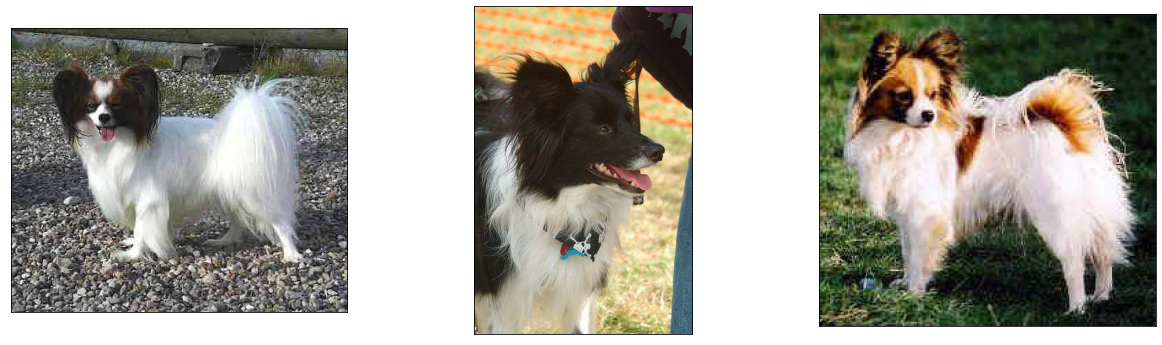

【 sealyham_terrier 】


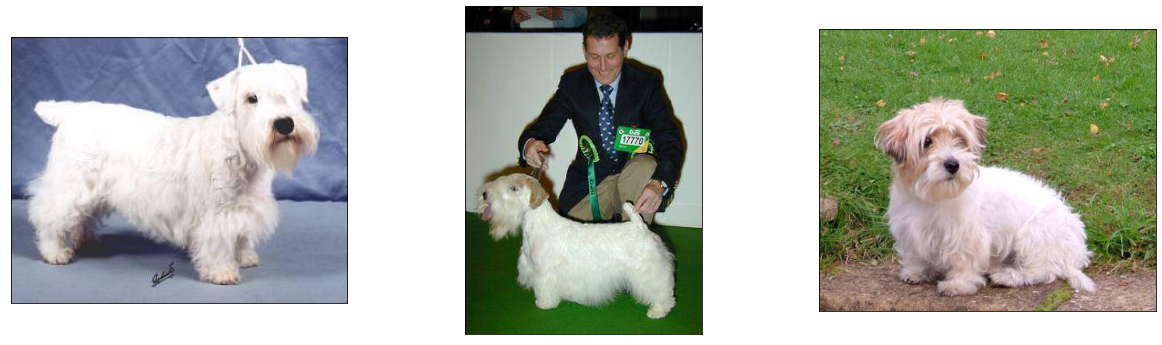

【 dingo 】


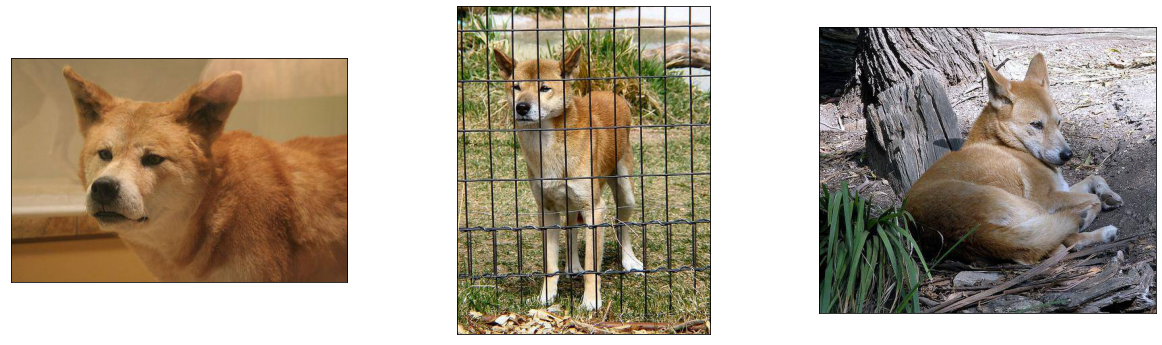

In [8]:
label_list = train_df['breed'].unique()

max_plot = 3 # 全犬種表示すると大変なので3犬種のみ表示
for count, label in enumerate(label_list):
    print('【', label, '】')
    
    img_list = train_df.query("breed == @label").head(max_plot)['id'].map(lambda x:'/kaggle/input/dog-image-dsg/photo/photo/' + x + '.jpg').values
    width = 35
    height = 35
    plt.figure(figsize=(width, height))
    for i in range(len(img_list)):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(plt.imread(img_list[i], 0))
    plt.show()
    
    # 指定した犬種まで表示
    if count >= max_plot-1:
        break

In [9]:
# ターゲットのエンコーディング対応
breed_list = list(train_df['breed'].unique())

target_to_breed = {}
breed_to_target = {}
for i, breed_i in enumerate(breed_list):
    target_to_breed[i] = breed_i
    breed_to_target[breed_i] = i

print(target_to_breed)
print(breed_to_target)

with open('target_to_breed.json', 'w') as fp:
    json.dump(target_to_breed, fp)

with open('breed_to_target.json', 'w') as fp:
    json.dump(breed_to_target, fp)

{0: 'papillon', 1: 'sealyham_terrier', 2: 'dingo', 3: 'bluetick', 4: 'malamute', 5: 'airedale', 6: 'shih-tzu', 7: 'chesapeake_bay_retriever', 8: 'pomeranian', 9: 'newfoundland', 10: 'cairn', 11: 'old_english_sheepdog', 12: 'blenheim_spaniel', 13: 'basset', 14: 'keeshond', 15: 'west_highland_white_terrier', 16: 'scottish_deerhound', 17: 'weimaraner', 18: 'boston_bull', 19: 'irish_setter', 20: 'saluki', 21: 'maltese_dog', 22: 'lhasa', 23: 'bloodhound', 24: 'rhodesian_ridgeback', 25: 'basenji', 26: 'leonberg', 27: 'silky_terrier', 28: 'bouvier_des_flandres', 29: 'kerry_blue_terrier', 30: 'samoyed', 31: 'beagle', 32: 'tibetan_terrier', 33: 'kelpie', 34: 'greater_swiss_mountain_dog', 35: 'irish_wolfhound', 36: 'norfolk_terrier', 37: 'english_foxhound', 38: 'wire-haired_fox_terrier', 39: 'schipperke', 40: 'entlebucher', 41: 'whippet', 42: 'norwegian_elkhound', 43: 'groenendael', 44: 'dandie_dinmont', 45: 'english_setter', 46: 'affenpinscher', 47: 'bedlington_terrier', 48: 'clumber', 49: 'ber

In [10]:
# 学習ラベルを変換する
train_df.replace(breed_to_target, inplace=True)

# 変換後の確認
train_df.head()

,id,breed
0,340fefc7ed26ad3ec072944df5350094,0
1,a63becb08aa9d4c47d5e4a948ae3ddf5,1
2,596f817b72a594a18153b1530cc384a0,2
3,8bd9f03c437e44fc390e90d05b1af1bf,3
4,0ec9be8b32f2b9eff2b817a7f722b118,4


In [11]:
CFG = {
    'fold_num': 5, # 交差検証を行う際のFoldの数
    'seed': 0,  # 乱数シードの固定
    'model_arch': 'resnet50_gn',  # 予測に用いるモデルの種類
    'data_root': '/kaggle/input/dog-image-dsg/photo/photo/',  # 学習・推論したい画像のファイルパス
    'working_path':'/kaggle/working/',
    'output_path':'/kaggle/working/',
    'target_col': 'breed',  # 予測したい列名
    'size': 224,  # 学習・推論時の画像サイズ
    'mean': [0.485, 0.456, 0.406],  # 画像を標準化する際の平均値(デフォルトとしてImagenetの統計値を指定) 
    'std': [0.229, 0.224, 0.225],  # 画像を標準化する際の標準偏差値(デフォルトとしてImagenetの統計値を指定) 
    'epochs': 5,  # Epcoch数
    'used_epochs':[], # 推論時にどのEpoch数のモデルを使うか(リスト指定なので、[4,5,6]のように指定すると3つのEpoch時のモデルでそれぞれ推論して平均の結果を返す)
    'train_bs': 16,  # 学習時のバッチサイズ
    'valid_bs': 16,  # 推論時のバッチサイズ
    'lr': 1e-4, # 学習率
    'step_size': 2, # スケジューラをによって学習率を何エポックごとに更新するか 
    'gamma': 0.9, # 学習率の更新率。更新タイミングで学習率をgamma倍にする
    'weight_decay':1e-6,  # 重み減衰
    'num_workers': 4,  # 並列化(CPUコア数を確認して指定)
    'debug': False  # デバッグ用で動作だけ確認したいときはTrue(データ量を削減して実行)
}

交差検証やめる

In [12]:
# 実験の再現性を確保するため、各処理での乱数シードを固定する
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = (torch.cuda.is_available() == 1)

In [13]:
# 画像のPathを受け取ってopencvで読み込んだ画像を返す
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

画像の前処理

In [14]:
# 学習用のデータ変換
def get_train_transforms():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((CFG['size'], CFG['size'])),
        transforms.Lambda(lambda image: image.convert('RGB')),
        transforms.ToTensor(),
        transforms.Normalize(mean=CFG['mean'], std=CFG['std'])
    ])
  
# 検証用のデータ変換
def get_valid_transforms():
    return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((CFG['size'], CFG['size'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=CFG['mean'], std=CFG['std'])
    ])

前処理によって変換された画像の確認

<class 'numpy.ndarray'>
***変換前***


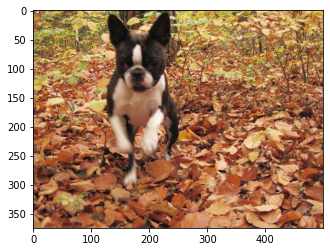

tensor([[[ 0.4851,  0.7077,  0.7077,  ...,  1.4783,  1.0844,  1.1015],
         [ 0.6392,  0.4508,  0.6906,  ...,  1.8379,  1.5297,  1.2385],
         [-0.0629, -0.0116,  1.1700,  ...,  1.7009,  1.7180,  1.5468],
         ...,
         [ 1.0844,  1.0331,  1.1187,  ...,  0.9303,  1.7352,  1.6324],
         [ 1.0844,  1.0502,  1.1358,  ...,  0.5536,  1.4269,  1.4783],
         [ 1.0159,  1.0673,  1.1358,  ...,  0.1939,  1.0331,  1.2043]],

        [[-0.4076, -0.1099,  0.0301,  ...,  1.1856,  0.7129,  0.6954],
         [-0.1099, -0.2325,  0.1001,  ...,  1.5182,  1.1506,  0.8179],
         [-0.6702, -0.5651,  0.7129,  ...,  1.2731,  1.3081,  1.1155],
         ...,
         [ 0.0651,  0.0126,  0.1176,  ...,  0.1176,  0.9755,  0.8704],
         [ 0.0651,  0.0301,  0.1352,  ..., -0.3550,  0.6254,  0.7129],
         [-0.0049,  0.0476,  0.1352,  ..., -0.8277,  0.2052,  0.4503]],

        [[-1.0201, -0.7587, -0.6890,  ..., -0.4973, -0.6367, -0.4275],
         [-0.6367, -0.7761, -0.5147,  ..., -0

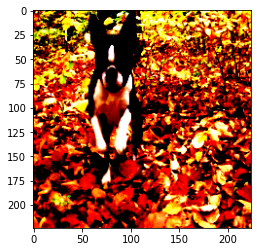

In [15]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる
# 1. 画像読み込み
image_file_path = '/kaggle/input/dog-image-dsg/photo/photo/000bec180eb18c7604dcecc8fe0dba07.jpg'
img = get_img(image_file_path)   # [高さ][幅][色RGB]

print(type(img))

# 2. 元の画像の表示
print("***変換前***")
plt.imshow(img)
plt.show()

# 学習用の画像変換
transform = get_train_transforms()
print(transform(img))
print(transform(img).dtype)
print(transform(img).shape)
img_transformed = transform(img)

print("***変換後***")
# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

Dataset Class

In [16]:
class DogDataset(data.Dataset):
    """
    犬画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    df : DataFrame
        正解ラベルの入ったデータフレーム
    data_root : str
        画像のパス
    transform : object
        前処理クラス
    output_label : bool
        正解ラベルがわかっている場合はTrue
    """

    def __init__(self,
                 df,
                 data_root, 
                 transforms=None, 
                 output_label=True):
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.output_label=output_label
        if output_label == True:
            self.labels = self.df[CFG['target_col']].values
    
    def __len__(self):
        '''画像の枚数を返す'''
        return self.df.shape[0]

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''
        
        # ラベルの取得
        if self.output_label == True:
            target = self.labels[index]
          
        # index番目の画像をロード
        img_path = self.data_root + self.df.loc[index]['id'] + '.jpg'
        img = get_img(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transforms(img)

        # 正解ラベルがある場合は、変換後の画像とラベルを両方返す
        if self.output_label == True:
            return img_transformed, target
        else:
            return img_transformed

Model

In [17]:
class DogImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained) # timmからモデルを読み込んで転移学習を行う
        # pretrainedのモデルと今回のデータセットでは出力したいクラス数が異なるためモデルの最終層のアーキテクチャを組み替える
        self.model.reset_classifier(n_class,'avg')

    def forward(self, x):
        x = self.model(x)
        return x

view関数、テンソルの形状の意味

dataloader

In [18]:
def prepare_dataloader(df,
                       trn_idx,
                       val_idx,
                       data_root=CFG['data_root']):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)

    # 学習用のデータセットを読み込む
    train_ds = DogDataset(train_, 
                              data_root, 
                              transforms=get_train_transforms(), 
                              output_label=True)
    
    # 検証用のデータセットを読み込む
    valid_ds = DogDataset(valid_, 
                              data_root, 
                              transforms=get_valid_transforms(), 
                              output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False, # TrueにするとCPUのメモリ領域がページングされないようになる
        drop_last=False,  # Trueにするとデータ数がバッチサイズで割り切れないときの最後のミニバッチを使用しなくなる
        shuffle=True,        
        num_workers=CFG['num_workers'],
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

In [19]:
trn_idx = sorted(random.sample(range(train_df.shape[0]), k = int(0.8 * train_df.shape[0])))
val_idx = list(filter(lambda x: x not in trn_idx ,list(range(train_df.shape[0]))))
print(len(trn_idx))
print(len(val_idx))
print(len(trn_idx)+len(val_idx))

3792
948
4740


学習

In [20]:
def training(train):
    """
    Attributes
    ----------
    train : DataFrame
        学習用のデータフレーム
    """

    # シードを統一
    seed_everything(CFG['seed'])
    
    # 分類するクラス数を指定
    class_values = train[CFG['target_col']].values
    class_num = train[CFG['target_col']].nunique()
    print("分類クラス数：", class_num)
    
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    
    # 学習データ、検証データに 8:2 の割合で分割する。
    
    trn_idx = sorted(random.sample(range(train.shape[0]), k = int(0.8 * train.shape[0])))
    val_idx = list(filter(lambda x: x not in trn_idx ,list(range(train.shape[0]))))
    
    
    print("-----------")
    print('学習開始')
    
    # train, validの数
    print("train:", len(trn_idx), " valid:", len(val_idx))
    
    # ネットワークのインスタンス生成
    model = DogImgClassifier(CFG['model_arch'],
                                 class_num,
                                 pretrained=True)
        
    # ネットワークをGPUへ
    model.to(device)
    
    print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')
        
    # 損失関数の設定
    # ここでは損失関数としてクロスエントロピーを指定
    criterion = nn.CrossEntropyLoss().to(device)

    # 最適化手法の設定
    # ここでは最適化手法としてAdamを指定
    optimizer = torch.optim.Adam(model.parameters(),
                                     lr=CFG['lr'], 
                                     weight_decay=CFG['weight_decay'])
        
    # スケジューラの設定
    # ここではStepLRを指定
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=['step_size'], gamma=CFG['gamma'])

    # 日時
    dt_now = datetime.datetime.now()

    # epochのループ
    for epoch in range(CFG['epochs']):
        print('Epoch {}/{}'.format(epoch+1, CFG['epochs'])) 
            
        # dataloader作成
        train_dataloader, val_dataloader = prepare_dataloader(train,
                                                                  trn_idx,
                                                                  val_idx,
                                                                  data_root=CFG['data_root'])
        # trainとvalidのdataloaderを管理
        dataloaders_dict = {'train':train_dataloader, 'val':val_dataloader}
            
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            # 開始時刻
            start = time.time()
            
            print("epoch", epoch, "---pahse", phase)
            if phase == 'train':
                model.train()  # モデルを訓練モードに
                    
                scaler = GradScaler() # ampの利用
                    
            else:
                model.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            val_preds = []
            val_true =[]
                
            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()
                    
                # 順伝搬（forward）計算(Scalerによる高速化)
                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():  # float32の保持や勾配の値のスケーリング等を自動的に行うことでTensorCoreを有効活用し、GPU計算の高速化・省メモリ化
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                # lossの合計を更新
                epoch_loss += loss.item() * inputs.size(0)  
                    
                # 正解数の合計を更新
                epoch_corrects += torch.sum(preds == labels.data)

                val_preds = np.concatenate([val_preds, preds.to('cpu').numpy()], 0)
                val_true = np.concatenate([val_true, labels.data.to('cpu').numpy()], 0)
                    
            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                    
            end = time.time() # 終了時刻
            t = end - start
            print(t, "秒")
            print('-------------')

            if phase == 'train':
              # 時間と精度の記録
              with open(CFG['output_path'] + 'train_data_gpu.csv' , 'a') as f:
                writer = csv.writer(f)
                if epoch == 0:
                  writer.writerow([dt_now])
                  writer.writerow(['時間','正解率'])
                writer.writerow([t,epoch_acc.item()])
            
            else:
              # 時間と精度の記録
              with open(CFG['output_path'] + 'val_data_gpu.csv' , 'a') as f:
                writer = csv.writer(f)
                if epoch == 0:
                  writer.writerow([dt_now])
                  writer.writerow(['時間','正解率'])
                writer.writerow([t,epoch_acc.item()])

    torch.cuda.empty_cache()
        

In [21]:
# デバッグ用のときはデータ量を減らして実行
if CFG['debug']:
    training(train_df.iloc[:1000]) 
else:
    training(train_df) 

分類クラス数： 73
使用デバイス： cuda:0
-----------
学習開始
train: 3792  valid: 948
ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました
Epoch 1/5
epoch 0 ---pahse train


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/237 [00:00<?, ?it/s]

train Loss: 1.8311 Acc: 0.6179
49.684433460235596 秒
-------------
epoch 0 ---pahse val


  0%|          | 0/60 [00:00<?, ?it/s]

val Loss: 0.6393 Acc: 0.8027
8.464417457580566 秒
-------------
Epoch 2/5
epoch 1 ---pahse train


  0%|          | 0/237 [00:00<?, ?it/s]

train Loss: 0.3256 Acc: 0.9022
47.328163385391235 秒
-------------
epoch 1 ---pahse val


  0%|          | 0/60 [00:00<?, ?it/s]

val Loss: 0.4500 Acc: 0.8629
8.654222011566162 秒
-------------
Epoch 3/5
epoch 2 ---pahse train


  0%|          | 0/237 [00:00<?, ?it/s]

train Loss: 0.1727 Acc: 0.9475
47.57990002632141 秒
-------------
epoch 2 ---pahse val


  0%|          | 0/60 [00:00<?, ?it/s]

val Loss: 0.4800 Acc: 0.8639
7.876309156417847 秒
-------------
Epoch 4/5
epoch 3 ---pahse train


  0%|          | 0/237 [00:00<?, ?it/s]

train Loss: 0.0948 Acc: 0.9707
48.20868539810181 秒
-------------
epoch 3 ---pahse val


  0%|          | 0/60 [00:00<?, ?it/s]

val Loss: 0.5407 Acc: 0.8449
7.970207214355469 秒
-------------
Epoch 5/5
epoch 4 ---pahse train


  0%|          | 0/237 [00:00<?, ?it/s]

train Loss: 0.0432 Acc: 0.9876
47.85738182067871 秒
-------------
epoch 4 ---pahse val


  0%|          | 0/60 [00:00<?, ?it/s]

val Loss: 0.4951 Acc: 0.8766
8.137440204620361 秒
-------------


In [22]:
#os.remove('/kaggle/working/train_data_gpu.csv')
#os.remove('/kaggle/working/val_data_gpu.csv')